<a href="https://colab.research.google.com/github/bdstel/Machine-Learning/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Username: **bradensteller**

In [ ]:
# Common imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing

# Keras
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.optimizers import SGD

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, mean_squared_error
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, GridSearchCV, train_test_split

In [ ]:
train_metadata = pd.read_csv("/content/drive/MyDrive/CAP4611 Assignment 5/assignment5_training_data_metadata.csv").drop(columns = ['id'])
test_metadata = pd.read_csv("/content/drive/MyDrive/CAP4611 Assignment 5/assignment5_test_data_metadata.csv").drop(columns = ['id'])

In [ ]:
train_metadata

,image_name,label,cause,type
0,IM-0128-0001.jpeg,Normal,NaN,NaN
1,IM-0127-0001.jpeg,Normal,NaN,NaN
2,IM-0125-0001.jpeg,Normal,NaN,NaN
3,IM-0122-0001.jpeg,Normal,NaN,NaN
4,IM-0119-0001.jpeg,Normal,NaN,NaN
...,...,...,...,...
5281,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,Pnemonia,COVID-19,Virus
5282,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,Pnemonia,COVID-19,Virus
5283,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,Pnemonia,COVID-19,Virus
5284,1-s2.0-S0140673620303706-fx1_lrg.jpg,Pnemonia,COVID-19,Virus


You can see above that there are quite a few null values. Let's summarize the dataset to see:

In [ ]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5286 entries, 0 to 5285
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  5286 non-null   object
 1   label       5286 non-null   object
 2   cause       69 non-null     object
 3   type        3944 non-null   object
dtypes: object(4)
memory usage: 165.3+ KB


The null values in the type column all correspond to where the label column is Normal. Since we're ultimately going to be using the type column for predictions, I think it's best to just have all of those values be set to "Normal" so that we have all 4 labels within the type column.

As for the other null values, they aren't as important, since the model won't worry about whether the x-ray is of pneumonia or COVID, only if it is one of the 4 types, and thus I won't be changing these at all.

In [ ]:
train_metadata['type'] = train_metadata['type'].fillna("Normal")

train_metadata

,image_name,label,cause,type
0,IM-0128-0001.jpeg,Normal,NaN,Normal
1,IM-0127-0001.jpeg,Normal,NaN,Normal
2,IM-0125-0001.jpeg,Normal,NaN,Normal
3,IM-0122-0001.jpeg,Normal,NaN,Normal
4,IM-0119-0001.jpeg,Normal,NaN,Normal
...,...,...,...,...
5281,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,Pnemonia,COVID-19,Virus
5282,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,Pnemonia,COVID-19,Virus
5283,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,Pnemonia,COVID-19,Virus
5284,1-s2.0-S0140673620303706-fx1_lrg.jpg,Pnemonia,COVID-19,Virus


Out of the whole dataset, only two of the samples are lungs of a Stress-Smoker. Because of this, I will treat them as outliers and remove them from the dataset.

While I don't think it's absolutely necessary, because the images are probably already sorted, I'll sort the dataset based on the image name so that they are in the same order as in the image folder.

In [ ]:
train_metadata.sort_values('image_name')

train_metadata

,image_name,label,cause,type
0,IM-0128-0001.jpeg,Normal,NaN,Normal
1,IM-0127-0001.jpeg,Normal,NaN,Normal
2,IM-0125-0001.jpeg,Normal,NaN,Normal
3,IM-0122-0001.jpeg,Normal,NaN,Normal
4,IM-0119-0001.jpeg,Normal,NaN,Normal
...,...,...,...,...
5281,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,Pnemonia,COVID-19,Virus
5282,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,Pnemonia,COVID-19,Virus
5283,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,Pnemonia,COVID-19,Virus
5284,1-s2.0-S0140673620303706-fx1_lrg.jpg,Pnemonia,COVID-19,Virus


Importing the images into a dataset was something else. I tried a bunch of different methods for hours on hours before I discovered that flow_from_dataframe existed, and it made my life so much easier.

The ImageDataGenerator handles the issue of if images are rotated, scaled improperly, etc. Essentially, it just adds a ton more images to the dataset using a bunch of the specified metrics of rotation, shear, rescale, zoom, and everything else. From that, I simply just imported the images and ensured that they were all 256x256.

In [ ]:
img_size = 128
batch_size = 32

train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   validation_split = 0.2)

train_data = train_datagen.flow_from_dataframe(train_metadata,
                                               directory = "/content/drive/MyDrive/CAP4611 Assignment 5/images/train",
                                               x_col = 'image_name',
                                               y_col = 'type',
                                               shuffle = True,
                                               target_size = (img_size, img_size),
                                               classes = ['Normal', 'Virus', 'bacteria', 'Stress-Smoking'],
                                               class_mode = 'categorical',
                                               seed = 1337,
                                               batch_size = batch_size,
                                               subset = 'training')

val_data = train_datagen.flow_from_dataframe(train_metadata,
                                             directory = "/content/drive/MyDrive/CAP4611 Assignment 5/images/train",
                                             x_col = 'image_name',
                                             y_col = 'type',
                                             shuffle = True,
                                             target_size = (img_size, img_size),
                                             classes = ['Normal', 'Virus', 'bacteria', 'Stress-Smoking'],
                                             class_mode = 'categorical',
                                             seed = 1337,
                                             batch_size = 10,
                                             subset = 'validation')

train_data

Found 4229 validated image filenames belonging to 4 classes.
Found 1057 validated image filenames belonging to 4 classes.


Let's visualize a few of the images to see if everything ended up working out properly.

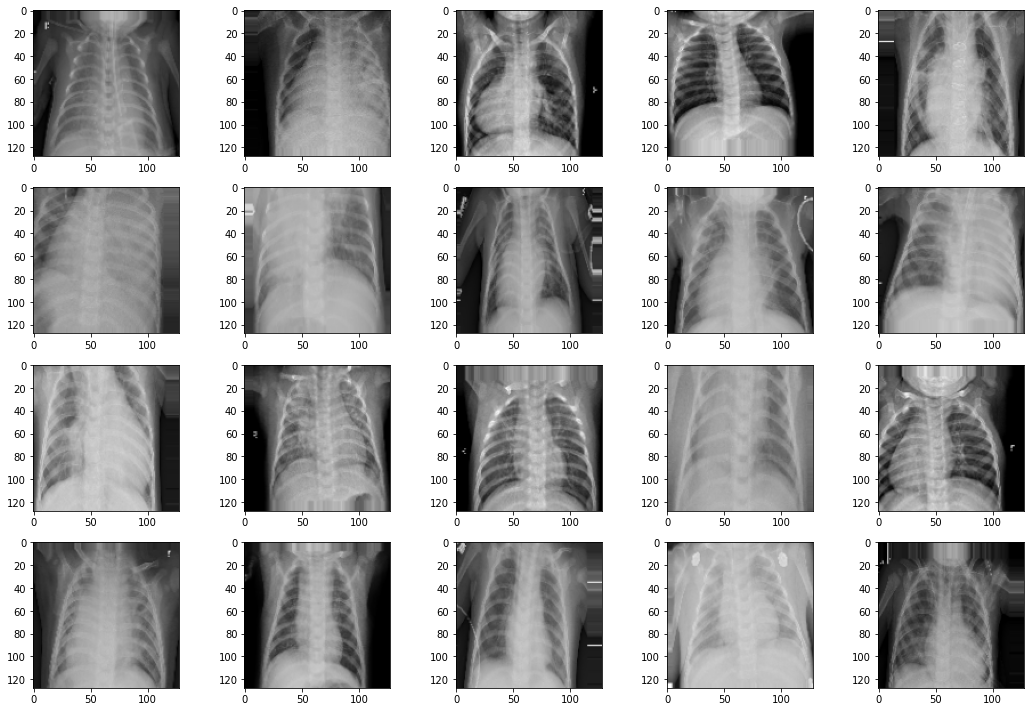

In [ ]:
plt.figure(figsize = (15, 10))

for i in range(0, 20):
  plt.subplot(4, 5, i + 1)
  for x_batch, y_batch in train_data:
    image = x_batch[0]
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)
    break

plt.tight_layout()
plt.show()

In order to help me prevent overfitting, I'm going to set up some callbacks to ensure that it doesn't continue learning if it's not gaining accuracy or decreasing loss.

In [ ]:
earlystop = EarlyStopping(patience = 5)
checkpoint = ModelCheckpoint("./checkpoints/model-{epoch:02d}.hdf5",
                             monitor = 'val_accuracy',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max',
                             save_freq = 'epoch')

callbacks = [earlystop, checkpoint]

It's time to build the model. The layers I used are self-explanatory, and I saved the model fitting into *history* so that I can use it to graph out the classification accuracy.

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), kernel_regularizer = 'l2', padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.1))

model.add(Conv2D(32, kernel_size = (3, 3), kernel_regularizer = 'l2', padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.1))

model.add(Conv2D(32, kernel_size = (3, 3), kernel_regularizer = 'l2', padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.1))

model.add(Conv2D(32, kernel_size = (3, 3), kernel_regularizer = 'l2', padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

history = model.fit(train_data, epochs = 50, validation_data = val_data, validation_steps = 1057//10, steps_per_epoch = 4229//batch_size, callbacks = callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0

Now that the model is fit to the training data, let's graph out how it performed

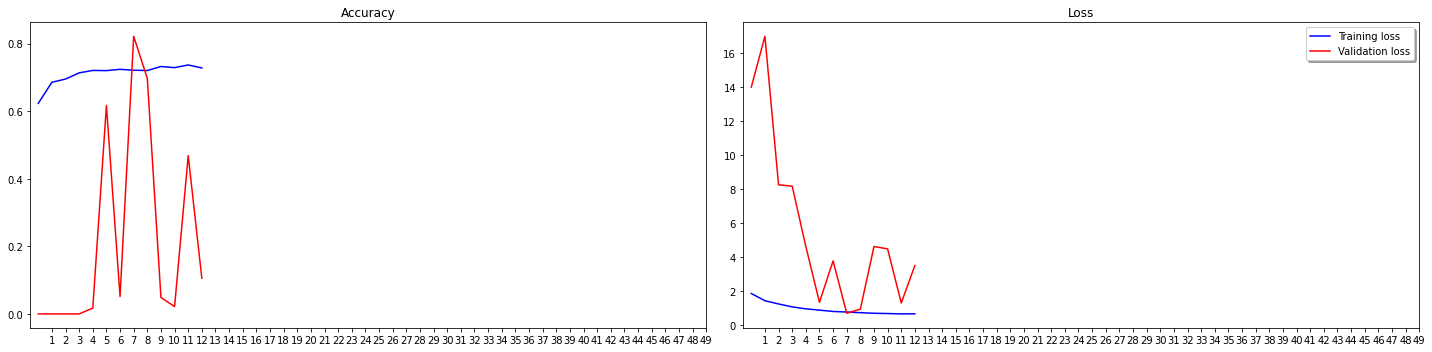

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))

ax1.plot(history.history['accuracy'], color = 'b', label = "Training accuracy")
ax1.plot(history.history['val_accuracy'], color = 'r',label = "Validation accuracy")
ax1.title.set_text('Accuracy')
ax1.set_xticks(np.arange(1, 50, 1))

ax2.plot(history.history['loss'], color = 'b', label = "Training loss")
ax2.plot(history.history['val_loss'], color = 'r', label = "Validation loss")
ax2.title.set_text('Loss')
ax2.set_xticks(np.arange(1, 50, 1))

plt.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.show()

The model is trained, the performance looks good, so it's time to predict.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_dataframe(test_metadata,
                                             "/content/drive/MyDrive/CAP4611 Assignment 5/images/test", 
                                             x_col = 'image_name',
                                             y_col = None,
                                             class_mode = None,
                                             target_size = (img_size, img_size),
                                             seed = 1337,
                                             shuffle = True,
                                             batch_size = batch_size)

Found 624 validated image filenames.


In [ ]:
model = load_model('./checkpoints/model-08.hdf5') # Best Model from Checkpoints Callback

predict = np.argmax(model.predict(test_data), axis=-1)

In [ ]:
predict = predict + 1
print(len(predict))
predict

624


array([1, 3, 4, 4, 1, 3, 4, 4, 3, 1, 3, 4, 1, 3, 3, 3, 1, 1, 3, 4, 4, 3,
       1, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4,
       3, 4, 4, 3, 1, 3, 3, 3, 4, 4, 1, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3,
       3, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 3, 4, 4, 4, 1, 3, 1, 4, 4, 4,
       3, 4, 4, 4, 1, 4, 4, 3, 4, 4, 4, 3, 4, 4, 1, 4, 3, 1, 4, 4, 3, 3,
       1, 4, 4, 4, 4, 1, 4, 3, 4, 4, 1, 3, 1, 4, 4, 4, 4, 4, 3, 1, 1, 1,
       4, 1, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4,
       4, 3, 4, 1, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 1, 3, 4, 4,
       4, 3, 4, 1, 4, 4, 4, 3, 1, 4, 4, 4, 1, 1, 3, 4, 3, 3, 4, 1, 4, 4,
       3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 4,
       3, 4, 4, 3, 3, 3, 4, 4, 3, 4, 3, 4, 3, 4, 1, 4, 4, 3, 4, 1, 4, 4,
       4, 4, 4, 4, 3, 3, 4, 3, 3, 1, 3, 1, 3, 3, 4, 4, 4, 4, 4, 3, 1, 4,
       4, 1, 1, 4, 4, 3, 1, 4, 1, 4, 4, 4, 1, 3, 1, 1, 4, 3, 3, 3, 4, 4,
       3, 3, 1, 4, 3, 4, 3, 1, 3, 3, 4, 1, 4, 3, 4,

In [ ]:
output = pd.DataFrame({'id': np.arange(5309, 5309 + 624), 'type': predict})
output = output.set_index('id')
print(output)
output.to_csv('my_submission.csv')

      type
id        
5309     1
5310     3
5311     4
5312     4
5313     1
...    ...
5928     3
5929     3
5930     4
5931     4
5932     1

[624 rows x 1 columns]
